In [1]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from osgeo import gdal, ogr, osr
import imageio

# Split France into train/val/test grid

In [2]:
# Custom colormap with 3 colors
c1 = [155, 205, 255] # KEEP THIS, DON'T OVERWRITE
c2 = [70, 130, 255]  # KEEP THIS, DON'T OVERWRITE
c3 = [255, 135, 50]  # KEEP THIS, DON'T OVERWRITE
c1 = [c / 256 for c in c1]
c2 = [c / 256 for c in c2]
c3 = [c / 256 for c in c3]
myColors = ((*c1, 1.0), (*c2, 1.0), (*c3, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

In [3]:
# Generate image grid once, then save
load_grid = True # False
n_grid_side = 20
grid_fn = '../data/splits/india_grid_{}x{}.npy'.format(n_grid_side, n_grid_side)
n_val = int(n_grid_side**2 * 0.15)
n_test = int(n_grid_side**2 * 0.15)
n_train = n_grid_side**2 - n_val - n_test
if not load_grid:
    image_grid_list = n_train * [0] + n_val * [1] + n_test * [2]
    np.random.shuffle(image_grid_list)
    image_grid = np.array(image_grid_list).reshape(n_grid_side, n_grid_side)
    np.save(grid_fn, image_grid)
    print('Saved {} India grid!'.format(image_grid.shape))
else:
    image_grid = np.load(grid_fn)
    print('Loaded {} India grid!'.format(image_grid.shape))

Loaded (20, 20) India grid!


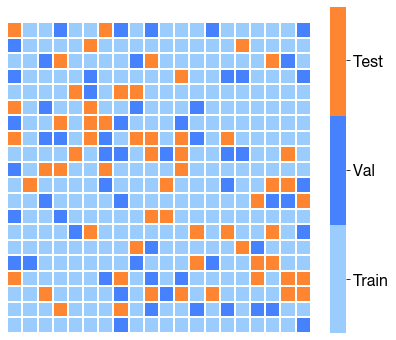

In [25]:
# Displaying spatial grid
plt.figure(figsize=(6.8,6))
ax = sns.heatmap(image_grid, cmap=cmap, linewidths=1.0)
plt.ylim([0,21])
plt.axis('off')
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=16)
colorbar.set_ticks([0.33,1,1.67])
colorbar.set_ticklabels(['Train', 'Val', 'Test'])
plt.show()

# Load and assign images to train/val/test

In [5]:
min_lon = 68
min_lat = 9
max_lon = 97
max_lat = 35
delta_lon = max_lon - min_lon
delta_lat = max_lat - min_lat
n_grid_side = 20
splits_dict = {0: 'train', 1: 'val', 2: 'test'}

image_df = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_download_v2.csv')
raster_splits = []

for i, row in image_df.iterrows():
    
    lon, lat = row['min_lon'], row['min_lat']
    
    # Find which grid cell the image falls into
    x_grid = (lat - min_lat) / (delta_lat / n_grid_side)
    y_grid = (lon - min_lon) / (delta_lon / n_grid_side)
    
    # Translate grid cell to split
    which_split = splits_dict[image_grid[int(x_grid), int(y_grid)]]
    raster_splits.append(which_split)

In [6]:
image_df['fold'] = raster_splits
image_df = image_df.rename({'min_lat': 'lat', 'min_lon': 'lon'}, axis=1)
image_df[['image_id', 'lat', 'lon', 'fold']].to_csv(
    '../data/splits/india_planetImagery_splits_20x20_v2.csv', index=False)

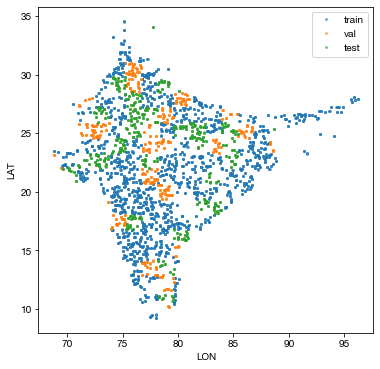

In [22]:
splits_df = pd.read_csv('../data/splits/india_planetImagery_splits_20x20.csv')

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(splits_df[splits_df['fold'] == 'train']['lon'],
         splits_df[splits_df['fold'] == 'train']['lat'], 'o', ms=2, alpha=0.5)
plt.plot(splits_df[splits_df['fold'] == 'val']['lon'],
         splits_df[splits_df['fold'] == 'val']['lat'], 'o', ms=2, alpha=0.5)
plt.plot(splits_df[splits_df['fold'] == 'test']['lon'],
         splits_df[splits_df['fold'] == 'test']['lat'], 'o', ms=2, alpha=0.5)
plt.xlabel('LON')
plt.ylabel('LAT')
plt.legend(['train', 'val', 'test'])
plt.show()

In [29]:
splits_df.groupby('fold').size()

fold
test     1071
train    3390
val       819
dtype: int64

## Subsample to smaller training set

In [10]:
splits_df.head()

,image_id,lat,lon,fold,sample_id
0,0,26.291410,73.095543,test,0000
1,115,26.008257,72.935907,test,0115
2,501,22.716429,82.110905,train,0501
3,781,22.557453,85.232995,test,0781
4,794,25.755859,82.609664,train,0794


In [19]:
splits_df = pd.read_csv('../data/splits/india_planetImagery_splits_20x20_v2.csv')
splits_df['sample_id'] = splits_df['image_id'].astype(str).str.zfill(4)
new_df = splits_df.copy()
new_df = new_df.drop_duplicates(['sample_id'])

In [26]:
# n_train = 20 # 100 fields
# n_train = 40 # 200 fields
# n_train = 100 # 500 fields
# n_train = 200 # 1000 fields
# n_train = 400 # 2000 fields
n_train = 1000 # 5000 fields

valtest = new_df[(new_df['fold'] == 'val') | (new_df['fold'] == 'test')]

train = new_df[new_df['fold'] == 'train']
train_new = train.sample(n=n_train, replace=False, random_state=0)

new_splits = pd.concat([train_new, valtest])
new_splits = splits_df[['sample_id', 'image_id', 'lat', 'lon']].merge(
    new_splits[['sample_id', 'fold']], on='sample_id', how='right')

new_splits.to_csv('../data/splits/india_planetImagery_splits_20x20_n{}.csv'.format(n_train), index=False)

In [20]:
splits_df.groupby('fold').size()

fold
none       22
test      399
train    1281
val       300
dtype: int64

In [27]:
new_splits.groupby('fold').size()

fold
test      399
train    1000
val       300
dtype: int64